In [1]:
import os
file_path = 'visual_sensory_moving2'
signs_class = [cla for cla in os.listdir(file_path)]
print(signs_class)

['dog', 'know', 'feel', 'bowl', 'must', 'get', 'sick', 'i', 'zero', 'you']


In [98]:
# 递归删除文件夹
import shutil
shutil.rmtree('visual_sensory_moving2/must')

In [102]:
# 创建 训练集train文件夹，并由类名在其目录下创建5个子目录
def mkfile(file):
    if not os.path.exists(file):
        os.makedirs(file)

mkfile('moving2/train')
for cla in signs_class:
    mkfile('moving2/train/' + cla)

mkfile('moving2/val')
for cla in signs_class:
    mkfile('moving2/val/' + cla)

In [103]:
#划分train和val,并构建seperate的train和val集

from shutil import copy
import random
 
# 划分比例， 每个类别下的测试集: 训练集 
split_rate = 1/5
 
# 遍历所有类别的全部图像并按比例分成训练集和验证集
for cla in signs_class: #每一个class
    cla_path = file_path + '/' + cla + '/'  # 某一类别的子目录
    images = os.listdir(cla_path)  # iamges 列表存储了该目录下所有图像的名称
    num = len(images)
    eval_index = random.sample(images, k=int(num*split_rate)) #从images中，随机抽取k个
    #print(eval_index) 随机划分训练和验证集
    
    for index, image in enumerate(images): #如图像a(1).jpg,那么index是1,image是a(1).jpg
        # every image is processed, and is stored to a new folder according to its attribute of train or val

        # some old images are val images, they need to store into new folder of val
        if image in eval_index:
            image_path = cla_path + image #original image path
            new_path = 'moving2/val/' + cla #new path(val folder)
            copy(image_path, new_path)  # old image to new folder
 
        # other old images store into new folder of train
        else:
            image_path = cla_path + image #original image path
            new_path = 'moving2/train/' + cla #new path(train folder)
            copy(image_path, new_path) # old image to new folder

        print("\r[{}] processing [{}/{}]".format(cla, index + 1, num), end="")  # processing schedule

        #\r:回到行首
    
    print() #\n
 
print("processing done!")

[dog] processing [2736/2736]
[know] processing [2535/2535]
[feel] processing [2702/2702]
[bowl] processing [2666/2666]
[must] processing [2638/2638]
[get] processing [2681/2681]
[sick] processing [2647/2647]
[i] processing [2605/2605]
[zero] processing [2617/2617]
[you] processing [2621/2621]
processing done!


In [1]:
# resnet-18 

import torch
import torch.nn as nn
import torch.nn.functional as F

#定义残差块ResBlock

class ResBlock(nn.Module):
    def __init__(self, inchannel, outchannel, identity_downsample=None, stride=1):
        super(ResBlock, self).__init__()
        
        #这里定义了残差块内连续的2个卷积层
        self.conv1 = nn.Conv2d(inchannel,outchannel,kernel_size=3,stride=stride,padding=1)
        self.bn1 = nn.BatchNorm2d(outchannel)
        self.conv2 = nn.Conv2d(outchannel,outchannel,kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(outchannel)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
            
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        
        # if identity_downsample is not None as default, then:
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        
        x = x + identity
        x = self.relu(x)
        
        return x

/root/miniconda3/envs/myconda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ResNet_18(nn.Module):
    
    def __init__(self, image_channels, num_classes):
        
        super(ResNet_18, self).__init__()
        # self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def identity_downsample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels)
        )  
    
    def __make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None #默认是none,即identity-free shortcut
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
        #对于64-128.128-256.256-512的第一个block,有stride=2,且outchannel=2*inchannel；
        #其他的block,64-64的全部2个,64-128的第2个，128-256的第2个，256-512的第2个，都是outchannel=inchannel
            
        return nn.Sequential(
            ResBlock(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            ResBlock(out_channels, out_channels)
        )
    
    def forward(self, x):
        x = x.reshape((-1, 3, 224, 224))
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 
    

In [3]:
model = ResNet_18(3,10)

device = torch.device("cuda:0" if torch.cuda.is_available () else "cpu")

model = model.to(device) # or MyNet().to(device)

In [11]:
from torchvision import transforms # first, we need to preprocess(i.e.transform) the train/val sets
# then we need to load all the train / val sets
from torchvision.datasets import ImageFolder 
from torch.utils.data import DataLoader
import torch
from PIL import Image
from torch.utils.data import TensorDataset, DataLoader

rootDir = "/root/visual_sensory_moving2"
# ROOT_TRAIN = "../visual_sensory_moving2"
# ROOT_TEST = "../visual_sensory_moving2" # test is val in our case
transforms = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Resize((224,224)), # 裁剪为224*224
    ])
labelName = ["bowl", "dog", "feel", "get", "I", "know", "must", "sick", "you", "zero"]
labelBias = [128, 51, 72, 91, 114, 152, 129, 110, 145, 132]
labelCount = [2666, 2736, 2702, 2681, 2605, 2535, 2637, 2647, 2621, 2617]
label = 0
rawTensorDataSets = []
trainingRatio = 0.8
batchSize = 64
device = torch.device("cuda")

for i in range(len(labelName)):
    name = labelName[i]
    bias = labelBias[i]
    count = labelCount[i]
    tensorImgSets = []
    for j in range(count):
        img = Image.open(rootDir+"/%s/%s%04d.png" %(name, name, bias+j))
        tensorImg = transforms(img)
        tensorImg = tensorImg.reshape((1,-1)) # must be 1 * (3 * 224 * 224)
        if j == 0:
            tensorImgSets = tensorImg
        else:
            tensorImgSets = torch.concat((tensorImgSets, tensorImg), dim=0)
    print(tensorImgSets.shape)
    
    imgLabels = torch.zeros((tensorImgSets.shape[0], 1), dtype=torch.uint8) # tensor.shape[0]:2666/2736/....
    imgLabels += label
    tensorImgSets = torch.concat((tensorImgSets, imgLabels), dim=-1)
    label += 1
    
    if i == 0:
        rawTensorDataSets = tensorImgSets
    else:
        rawTensorDataSets = torch.concat((rawTensorDataSets, tensorImgSets), dim=0) # must be M * (3 * 224 * 224 + 1)
        
torch.save(rawTensorDataSets, "/root/nonshuffle-rawDatasets.pt")

'''
# torch.save(rawTensorDataSets, "/root/rawDatasets.pt")
rawTensorDataSets = rawTensorDataSets[torch.randperm(rawTensorDataSets.size()[0])]
torch.save(rawTensorDataSets, "/root/rawDatasets.pt")
'''

torch.Size([2666, 150528])
torch.Size([2736, 150528])
torch.Size([2702, 150528])
torch.Size([2681, 150528])
torch.Size([2605, 150528])
torch.Size([2535, 150528])
torch.Size([2637, 150528])
torch.Size([2647, 150528])
torch.Size([2621, 150528])
torch.Size([2617, 150528])


'\n# torch.save(rawTensorDataSets, "/root/rawDatasets.pt")\nrawTensorDataSets = rawTensorDataSets[torch.randperm(rawTensorDataSets.size()[0])]\ntorch.save(rawTensorDataSets, "/root/rawDatasets.pt")\n'

In [4]:
# hyperparameters of the net:
# batch_size has been declared in loading the sets in step 2, the rest are loss_function, optimizer, and learning rate
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [5]:
# 定义训练函数
def train(dataloader, model, loss_fn, optimizer,device):
    loss, current, n = 0.0, 0.0, 0
    for batch_num, (x, label) in enumerate(dataloader):
 
        # 前向传播
        image, label = x.to(device), label.to(device)
        output = model(image)
        cur_loss = loss_fn(output, label)
        _, pred = torch.max(output, axis=1);# print(pred)
        cur_acc = torch.sum(label == pred)/output.shape[0]
 
        # 反向传播
        optimizer.zero_grad()
        cur_loss.backward()
        optimizer.step()
        loss += cur_loss.item()
        current += cur_acc.item()
        n = n+1 #n:batch_size数量
 
    # loss和acc是两个不同性质的变量
    #loss:损失本身,是一个通过特殊的交叉熵损失函数,得到的连续值
    #acc:准确率,是纯粹的正确百分比,例如头三个batch,正确情况为(10/16,5/16,7/16),那么acc=(10+5+7)/(16+16+16),或者acc=(10/16+5/16+7/16)/n (n=3)
    train_loss = loss/n
    train_acc = current/n
    print('train_loss:' + str(train_loss))
    print('train_acc:' + str(train_acc))
    return train_loss, train_acc

In [8]:
import torch
dataset = torch.load("/root/rawDatasets.pt")
print(dataset.shape)

torch.Size([26447, 150529])


In [14]:
print(dataset[56])

tensor([54, 52, 49,  ..., 34, 31,  3], dtype=torch.uint8)


In [6]:
from torchvision import transforms # first, we need to preprocess(i.e.transform) the train/val sets
# then we need to load all the train / val sets
from torchvision.datasets import ImageFolder 
from torch.utils.data import DataLoader
import torch
from PIL import Image
from torch.utils.data import TensorDataset, DataLoader

# ROOT_TRAIN = "../visual_sensory_moving2"
# ROOT_TEST = "../visual_sensory_moving2" # test is val in our case
transforms = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Resize((224,224)), # 裁剪为224*224
    ])
labelName = ["bowl", "dog", "feel", "get", "I", "know", "must", "sick", "you", "zero"]
labelBias = [128, 51, 72, 91, 114, 152, 129, 110, 145, 132]
labelCount = [2666, 2736, 2702, 2681, 2605, 2535, 2637, 2647, 2621, 2617]
label = 0
rawTensorDataSets = []
trainingRatio = 0.8
batchSize = 256
device = torch.device("cuda")

rawTensorDataSets = torch.load("/root/rawDatasets.pt") # 打乱的视觉图像

totalCount = rawTensorDataSets.shape[0] 
trainingCount = int(totalCount * trainingRatio)

trainingData = rawTensorDataSets[0:trainingCount, 0:-1].to(dtype=torch.float32).to(device)
trainingLabel = rawTensorDataSets[0:trainingCount, -1].to(dtype=torch.long).to(device)
validatingData = rawTensorDataSets[trainingCount:, 0:-1].to(dtype=torch.float32).to(device)
validatingLabel = rawTensorDataSets[trainingCount:, -1].to(dtype=torch.long).to(device)

trainingDataSet = TensorDataset(trainingData, trainingLabel)
validatingDataSet = TensorDataset(validatingData, validatingLabel)

train_dataloader = DataLoader(trainingDataSet, batch_size=batchSize, shuffle=True)
val_dataloader = DataLoader(validatingDataSet, batch_size=batchSize, shuffle=True)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

acc_val=[]

device = torch.device("cuda")
net = ResNet_18(3,10)
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

iterr=[]
for i in range(20):
    iterr.append(i)
    
for epoch in range(20):
    statisticLoss = 0.0
    total = 0
    correct = 0
    # Training
    for i, (features, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = net(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        statisticLoss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    trainingAcc = 100 * correct / total
    
    # Validating
    total = 0
    correct = 0
    with torch.no_grad():
        for i, (features, labels) in enumerate(val_dataloader):
            # features
            # features1, features2 <= features
            # outputs1 = softmax(net1(features1))
            # outputs2 = softmax(net2(features2))
            # outputs = outputs1 * weight1 + outputs2 * weight2
            outputs = net(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    validatingAcc = 100 * correct / total
    acc_val.append(validatingAcc)

    print("Epoch %d, Average Training Loss: %.4lf, Training Accuracy: %.4lf%%, Validating Accuracy: %.4lf%%" %(epoch+1, statisticLoss, trainingAcc, validatingAcc))

torch.save(net, "/root/moving_visual_new.pth")

'''
plt.figure()
plt.plot(iterr,acc_val)
plt.title('Validating accuracy of visual_part')
plt.xlabel('epoch')
plt.ylabel('training accuracy')
plt.savefig('moving_visual.png')
plt.show()
'''

Epoch 1, Average Training Loss: 12.3608, Training Accuracy: 96.6867%, Validating Accuracy: 100.0000%
Epoch 2, Average Training Loss: 0.0407, Training Accuracy: 100.0000%, Validating Accuracy: 100.0000%
Epoch 3, Average Training Loss: 0.0229, Training Accuracy: 100.0000%, Validating Accuracy: 100.0000%
Epoch 4, Average Training Loss: 0.0155, Training Accuracy: 100.0000%, Validating Accuracy: 100.0000%
Epoch 5, Average Training Loss: 0.0115, Training Accuracy: 100.0000%, Validating Accuracy: 100.0000%
Epoch 6, Average Training Loss: 0.0085, Training Accuracy: 100.0000%, Validating Accuracy: 100.0000%
Epoch 7, Average Training Loss: 0.0069, Training Accuracy: 100.0000%, Validating Accuracy: 100.0000%
Epoch 8, Average Training Loss: 0.0059, Training Accuracy: 100.0000%, Validating Accuracy: 100.0000%
Epoch 9, Average Training Loss: 0.0049, Training Accuracy: 100.0000%, Validating Accuracy: 100.0000%
Epoch 10, Average Training Loss: 0.0043, Training Accuracy: 100.0000%, Validating Accuracy:

"\nplt.figure()\nplt.plot(iterr,acc_val)\nplt.title('Validating accuracy of visual_part')\nplt.xlabel('epoch')\nplt.ylabel('training accuracy')\nplt.savefig('moving_visual.png')\nplt.show()\n"

In [7]:
'''
因为0和1本质上是同一类，我是在同一类里选择了两个特征图，每隔特征图自成一类
同理，这个道理也应用于 2和3; 4和5; 6和7; ... ;18和19
'''
def merge_categories(label,pred):
    label=label.tolist(); pred=pred.tolist()
    for i in range(0,len(label),1):
        if label[i]==pred[i] or (label[i]%2==0 and label[i]+1==pred[i]) or (label[i]%2==1 and label[i]-1==pred[i]):
            pred[i]=label[i] #直接当作一类来处理，因为本来就是一类
    label=torch.tensor(label)
    pred=torch.tensor(pred)
    return label,pred

In [6]:
# 定义训练函数
# val部分不需要损失函数loss_fn和优化器optimizer,只需要求出对不对就行了
def test(dataloader, model):
    current,n = 0.0,0
    for batch_num, (x, label) in enumerate(dataloader):
        # 前向传播
        image, label = x.to(device), label.to(device)
        output = model(image)
        _, pred = torch.max(output, axis=1)
        # print("label: ",label);print("pred: ",pred)
        
        cur_acc = torch.sum(label == pred)/output.shape[0]
        
        current += cur_acc.item()
        n=n+1

    test_acc = current/n
    print('test_acc:' + str(test_acc))
    return test_acc

In [12]:
model = torch.load('moving_visual.pth')
device = torch.device("cuda:0" if torch.cuda.is_available () else "cpu") ; model = model.to(device) # deploy model on device
model.eval() # ready for the test

test_acc = test(val_dataloader, model)

test_acc:1.0


In [17]:
#个数
dictt = {'bowl':2666,'dog':2736,'feel':2702,'get':2681,'I':2605,'know':2535,'must':2638,'sick':2648,'you':2622,'zero':2617}
#开始行
dictt2 = {'bowl':2,'dog':2671,'feel':5410,'get':8115,'I':10799,'know':13407,'must':15945,'sick':18585,'you':21235,'zero':23859}
#bias
dictt3 = {'bowl':128,'dog':51,'feel':72,'get':91,'I':114,'know':152,'must':129,'sick':109,'you':144,'zero':132}

In [6]:
import csv
with open('CA2_sensor_moving_real.csv', newline='') as csvfile:  
    reader = csv.reader(csvfile)
    sensor = list(reader)

In [7]:
print(len(sensor))
print(sensor[0])

26476
['1681722697', 'bowl', '', '', '', '', '', '', '', '', '']


In [24]:
print('a'>'A')

True


In [28]:
def find_true_label(x):
    label=''
    for i in range(0,len(x),1):
        if x[i]>="A" and x[i]<="z":
            label=label+x[i]
        if x[i]<"A":
            break
    #print(label)
    return label

In [19]:
def find_sensor_index(x):
    index=''
    for i in range(0,len(x),1):
        if x[i]>="0" and x[i]<="9":
            index=index+x[i]
        if x[i]<"0":
            break
    #print(index)
    return int(index)

In [20]:
print(type(dictt2 [find_true_label("dog0051.png")]))

<class 'int'>


In [29]:
from PIL import Image
folder='moving2/train'

out_for_all_train=[]

normalize = transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),normalize])

# 加载模型，进入测试模式
model = torch.load('moving_visual.pth')
device = torch.device("cuda:0" if torch.cuda.is_available () else "cpu") ; model = model.to(device)
model.eval()
        
for i in os.listdir(folder):
    sub_folder=folder+'/'+i+'/'
    print(sub_folder)
    for j in os.listdir(sub_folder):
        #print(j)
        img_path=sub_folder+j
        img=Image.open(img_path)
        img = transform(img) ; img = torch.reshape(img,(1,3,224,224))
        # 得到model的1*10的tensor
        with torch.no_grad():
            img=img.to(device)
            out=model(img)
            # _, pred = torch.max(output, axis=1);print(pred)
            out=out.tolist(); out=out[0]
            out_img = out
        
        #sensor
        true_label=find_true_label(j) # dog0051.png→dog
        sensor_index=find_sensor_index(j) # dog0051.png→51
        real_sensor_index = dictt2[true_label] + (sensor_index-dictt3[true_label])-1
        out_sensor=sensor[real_sensor_index]
        
        #concate
        out_concate = out_img + out_sensor
        #print(out_concate)
        out_for_all_train.append(out_concate)
    

moving2/train/dog/
moving2/train/know/
moving2/train/feel/
moving2/train/bowl/
moving2/train/must/
moving2/train/get/
moving2/train/sick/
moving2/train/zero/
moving2/train/I/
moving2/train/you/


In [103]:
for i in range(0,len(out_for_all_train),1):
    for j in range(0,len(out_for_all_train[0]),1):
        if out_for_all_train[i][j]!='':
            out_for_all_train[i][j]=float(out_for_all_train[i][j])
        else:
            out_for_all_train[i][j]=0

In [80]:
from PIL import Image
folder='moving2/val'

out_for_all_val=[]

normalize = transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),normalize])

model = torch.load('moving_visual.pth')
device = torch.device("cuda:0" if torch.cuda.is_available () else "cpu") ; model = model.to(device)
model.eval()
    
for i in os.listdir(folder):
    sub_folder=folder+'/'+i+'/'
    print(sub_folder)
    for j in os.listdir(sub_folder):
        #print(j)
        img_path=sub_folder+j
        img=Image.open(img_path)
        img = transform(img) ; img = torch.reshape(img,(1,3,224,224))
        # 得到model的1*10的tensor
        with torch.no_grad():
            img=img.to(device)
            out=model(img)
            # _, pred = torch.max(output, axis=1);print(pred)
            out=out.tolist(); out=out[0]
            out_img = out
        
        #sensor
        true_label=find_true_label(j) # dog0051.png→dog
        sensor_index=find_sensor_index(j) # dog0051.png→51
        real_sensor_index = dictt2[true_label] + (sensor_index-dictt3[true_label])-1
        out_sensor=sensor[real_sensor_index]
        
        #concate
        out_concate = out_img + out_sensor
        #print(out_concate)
        out_for_all_val.append(out_concate)

moving2/val/dog/
moving2/val/know/
moving2/val/feel/
moving2/val/bowl/
moving2/val/must/
moving2/val/get/
moving2/val/sick/
moving2/val/zero/
moving2/val/I/
moving2/val/you/


In [105]:
for i in range(0,len(out_for_all_val),1):
    for j in range(0,len(out_for_all_val[0]),1):
        if out_for_all_val[i][j]!='':
            out_for_all_val[i][j]=float(out_for_all_val[i][j])
        else:
            out_for_all_val[i][j]=0

In [106]:
path  = "moving_train.csv"
with open(path,'w',newline='') as f:
    csv_write = csv.writer(f)
    csv_write.writerows(out_for_all_train)

In [107]:
path  = "moving_val.csv"
with open(path,'w',newline='') as f:
    csv_write = csv.writer(f)
    csv_write.writerows(out_for_all_val)

In [109]:
#保存临时变量
import pickle
def save_variable(v,filename):
    f=open(filename,'wb')
    pickle.dump(v,f,0)          
    f.close()                     
    return filename

save_variable(out_for_all_train,"out_for_all_train.txt")
save_variable(out_for_all_val,"out_for_all_val.txt")

'out_for_all_val.txt'

In [138]:
# 读取临时变量
file =open("out_for_all_val.txt", "rb")
out_for_all_train = pickle.load(file)
file.close()
print(len(out_for_all_val))

5287


In [111]:
folder='moving2/val'
for i in os.listdir('moving2/val'):
    sub_folder=folder+'/'+i+'/'
    print(sub_folder)
    files = os.listdir(sub_folder)
    print(len(files))

moving2/val/dog/
547
moving2/val/know/
507
moving2/val/feel/
540
moving2/val/bowl/
533
moving2/val/must/
527
moving2/val/get/
536
moving2/val/sick/
529
moving2/val/zero/
523
moving2/val/I/
521
moving2/val/you/
524


In [112]:
#num_train=[2189,2028,2162,2133,2111,2145,2118,2094,2084,2097]
num_train=[0,2189,4217,6379,8512,10623,12768,14886,16980,19064]

#num_val=[547,507,540,533,527,536,529,523,521,524]
num_val=[0,547,1054,1594,2127,2654,3190,3719,4242,4763]

In [113]:
# train_label顺序：dog-1, know-5, feel-2, bowl-0, must-6, get-3, sick-7,zero-9,I-4,you-8
# val_label顺序：dog-1, know-5, feel-2, bowl-0, must-6, get-3, sick-7,zero-9,I-4,you-8
# 实际按照字母的label顺序：bowl,dog,feel,get,I,know,must,sick,you,zero

In [114]:
print(len(out_for_all_train[0]))

21


In [117]:
con_train=[]
true_label=0

for i in range(0,len(out_for_all_train),1):
    if i<2189:
        true_label=1 #'dog'
    elif i<4217:
        true_label=5 #'know'
    elif i<6379:
        true_label=2 #'feel'
    elif i<8512:
        true_label=0 #'bowl'
    elif i<10623:
        true_label=6 #'must'
    elif i<12768:
        true_label=3 #'get'
    elif i<14886:
        true_label=7 #'sick'
    elif i<16980:
        true_label=9 #'zero'
    elif i<19064:
        true_label=4 #'I'
    else:
        true_label=8 #'you'
    
    
    tmp = torch.reshape(torch.Tensor(out_for_all_train[int(i)]),(1,1,21))
    tuple_tmp = (tmp,true_label)
    con_train.append(tuple_tmp)

In [121]:
print(len(con_train[0])) #内容和标签

2


In [119]:
print(con_train[0])

(tensor([[[ 1.4215e+00,  1.1726e+01,  6.1481e-01, -2.8843e+00, -3.0646e+00,
           3.6547e-01, -5.1642e+00,  2.2799e+00, -3.3378e-01, -1.5523e+00,
           1.8770e+01,  1.7790e+01,  1.9550e+01,  1.8330e+01,  1.7690e+01,
          -2.0000e-02,  5.9000e-01, -7.8000e-01,  1.4434e+02,  1.3000e+00,
           1.1082e+02]]]), 1)


In [122]:
con_val=[]
true_label=0

num_val=[0,547,1054,1594,2127,2654,3190,3719,4242,4763]

for i in range(0,len(out_for_all_val),1):
    if i<547:
        true_label=1 #'dog'
    elif i<1054:
        true_label=5 #'know'
    elif i<1594:
        true_label=2 #'feel'
    elif i<2127:
        true_label=0 #'bowl'
    elif i<2654:
        true_label=6 #'must'
    elif i<3190:
        true_label=3 #'get'
    elif i<3719:
        true_label=7 #'sick'
    elif i<4242:
        true_label=9 #'zero'
    elif i<4763:
        true_label=4 #'I'
    else:
        true_label=8 #'you'
    
    
    tmp = torch.reshape(torch.Tensor(out_for_all_val[int(i)]),(1,1,21))
    tuple_tmp = (tmp,true_label)
    con_val.append(tuple_tmp)

In [124]:
print(len(con_val))
print(con_val[100])

5287
(tensor([[[ 3.7326e+00,  1.4293e+01,  7.5368e-01, -2.9340e+00, -3.2860e+00,
          -2.8717e+00, -5.8422e+00,  3.1619e+00, -1.3851e+00, -1.7139e+00,
           1.9550e+01,  1.7600e+01,  2.1110e+01,  1.8130e+01,  1.7010e+01,
          -1.2000e-01,  4.8000e-01, -8.6000e-01,  1.5023e+02,  4.9200e+00,
           1.1064e+02]]]), 1)


In [ ]:
# 保存临时变量 con_train, con_val
import pickle
def save_variable(v,filename):
    f=open(filename,'wb')
    pickle.dump(v,f,0)          
    f.close()                     
    return filename

save_variable(con_train,"con_train.txt")
save_variable(con_val,"con_val.txt")

In [1]:
# 读取临时变量 con_train
import pickle
file = open("con_train.txt", "rb")
con_train = pickle.load(file)
file.close()
print(len(con_train))
print(con_train[0])

/root/miniconda3/envs/myconda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


21161
(tensor([[[ 1.4215e+00,  1.1726e+01,  6.1481e-01, -2.8843e+00, -3.0646e+00,
           3.6547e-01, -5.1642e+00,  2.2799e+00, -3.3378e-01, -1.5523e+00,
           1.8770e+01,  1.7790e+01,  1.9550e+01,  1.8330e+01,  1.7690e+01,
          -2.0000e-02,  5.9000e-01, -7.8000e-01,  1.4434e+02,  1.3000e+00,
           1.1082e+02]]]), 1)


In [2]:
# 读取临时变量
file = open("con_val.txt", "rb")
con_val = pickle.load(file)
file.close()
print(len(con_val))
print(con_val[0])

5287
(tensor([[[ 3.8492e+00,  1.2379e+01, -4.2075e-01, -2.1677e+00, -3.6769e+00,
          -2.4024e+00, -5.2719e+00,  2.1705e+00, -3.1040e-01, -6.5866e-01,
           1.8770e+01,  1.7110e+01,  2.0140e+01,  1.7690e+01,  1.7300e+01,
          -3.1000e-01,  1.0000e-01, -8.9000e-01,  1.7498e+02,  1.5790e+01,
           8.3490e+01]]]), 1)


In [3]:
import torch ; import numpy ; from torch.utils.data import DataLoader

train_dataloader2 = DataLoader(con_train, batch_size=64, shuffle=True, num_workers=0)
val_dataloader2 = DataLoader(con_val, batch_size=64, shuffle=True, num_workers=0)

In [9]:
for batch_num,(x,label) in enumerate(val_dataloader2):
    print(label)

tensor([5, 0, 3, 2, 8, 9, 9, 2, 9, 8, 5, 0, 8, 8, 6, 8])
tensor([1, 2, 8, 9, 0, 6, 4, 4, 0, 3, 3, 5, 6, 2, 1, 0])
tensor([5, 2, 4, 8, 2, 0, 3, 7, 0, 0, 6, 2, 1, 4, 6, 0])
tensor([7, 4, 2, 3, 4, 8, 0, 6, 4, 3, 2, 2, 8, 9, 6, 5])
tensor([7, 5, 4, 4, 4, 2, 7, 8, 4, 8, 4, 2, 2, 9, 4, 4])
tensor([4, 8, 9, 6, 9, 3, 5, 9, 9, 7, 7, 4, 9, 4, 7, 8])
tensor([9, 6, 3, 7, 1, 1, 9, 6, 7, 7, 4, 7, 1, 8, 1, 5])
tensor([5, 1, 4, 3, 2, 2, 0, 1, 1, 2, 4, 9, 0, 5, 3, 3])
tensor([0, 2, 3, 1, 2, 7, 9, 6, 9, 4, 3, 0, 9, 6, 8, 0])
tensor([8, 3, 8, 1, 3, 8, 0, 6, 9, 3, 2, 7, 3, 6, 2, 5])
tensor([4, 2, 9, 1, 7, 8, 2, 6, 0, 9, 6, 1, 0, 6, 6, 9])
tensor([6, 0, 7, 3, 8, 2, 3, 3, 5, 7, 2, 1, 6, 2, 8, 5])
tensor([9, 6, 6, 4, 0, 0, 5, 6, 1, 8, 0, 3, 6, 7, 5, 2])
tensor([6, 0, 4, 4, 7, 4, 4, 9, 7, 8, 2, 7, 3, 2, 1, 4])
tensor([7, 7, 8, 5, 7, 6, 9, 9, 6, 3, 7, 0, 4, 8, 4, 7])
tensor([1, 1, 8, 4, 2, 3, 3, 3, 2, 6, 9, 8, 6, 4, 4, 2])
tensor([4, 6, 2, 8, 5, 3, 5, 0, 1, 2, 6, 4, 7, 0, 5, 7])
tensor([9, 6, 3, 7, 4, 9, 0, 4,

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#  进入全连接层

class FC(nn.Module):
    def __init__(self):
        super(FC, self).__init__()
        self.hidden1=nn.Sequential(
                nn.Linear(in_features=21,out_features=18,bias=True), # 20+5 / 20+11
                nn.Dropout(p = 0.2),
                nn.ReLU())
        self.hidden2=nn.Sequential(
                nn.Linear(in_features=18,out_features=15,bias=True),
                nn.ReLU())
        self.hidden3=nn.Sequential(
                nn.Linear(in_features=15,out_features=10,bias=True),
                nn.ReLU())
        self.hidden4=nn.Sequential(
                nn.Linear(in_features=10,out_features=10,bias=True),
                nn.ReLU())

    def forward(self,x):
        x=self.hidden1(x)
        x=self.hidden2(x)
        x=self.hidden3(x)
        output=self.hidden4(x)
        #output = F.log_softmax(output, dim=1)
        return output

In [4]:
# resnet-18 

import torch
import torch.nn as nn
import torch.nn.functional as F

#定义残差块ResBlock

class ResBlock(nn.Module):
    def __init__(self, inchannel, outchannel, identity_downsample=None, stride=1):
        super(ResBlock, self).__init__()
        
        #这里定义了残差块内连续的2个卷积层
        self.conv1 = nn.Conv2d(inchannel,outchannel,kernel_size=3,stride=stride,padding=1)
        self.bn1 = nn.BatchNorm2d(outchannel)
        self.conv2 = nn.Conv2d(outchannel,outchannel,kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(outchannel)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
            
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        
        # if identity_downsample is not None as default, then:
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        
        x = x + identity
        x = self.relu(x)
        
        return x

In [5]:
class ResNet_18(nn.Module):
    
    def __init__(self, image_channels, num_classes):
        
        super(ResNet_18, self).__init__()
        # self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def identity_downsample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels)
        )  
    
    def __make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None #默认是none,即identity-free shortcut
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
        #对于64-128.128-256.256-512的第一个block,有stride=2,且outchannel=2*inchannel；
        #其他的block,64-64的全部2个,64-128的第2个，128-256的第2个，256-512的第2个，都是outchannel=inchannel
            
        return nn.Sequential(
            ResBlock(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            ResBlock(out_channels, out_channels)
        )
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 
    

In [6]:
model2 = ResNet_18(1,10)
device = torch.device("cuda:0" if torch.cuda.is_available () else "cpu")
model2 = model2.to(device) # or MyNet().to(device)

In [17]:
model2_new = FC()
device = torch.device("cuda:0" if torch.cuda.is_available () else "cpu")
model2_new = model2.to(device) # or MyNet().to(device)

In [18]:
# hyperparameters of the net:
# batch_size has been declared in loading the sets in step 2, the rest are loss_function, optimizer, and learning rate
loss_fn2 = nn.CrossEntropyLoss() # classification
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
# from torch.optim import lr_scheduler ; lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) # multiple 0.1 every 10 epochs

In [19]:
# 定义训练函数
def train(dataloader, model, loss_fn, optimizer,device):
    loss, current, n = 0.0, 0.0, 0
    for batch_num, (x, label) in enumerate(dataloader):
 
        # 前向传播
        image, label = x.to(device), label.to(device)
        output = model(image)
        cur_loss = loss_fn(output, label)
        _, pred = torch.max(output, axis=1);# print(pred)
        cur_acc = torch.sum(label == pred)/output.shape[0]
 
        # 反向传播
        optimizer.zero_grad()
        cur_loss.backward()
        optimizer.step()
        loss += cur_loss.item()
        current += cur_acc.item()
        n = n+1 #n:batch_size数量
 
    # loss和acc是两个不同性质的变量
    #loss:损失本身,是一个通过特殊的交叉熵损失函数,得到的连续值
    #acc:准确率,是纯粹的正确百分比,例如头三个batch,正确情况为(10/16,5/16,7/16),那么acc=(10+5+7)/(16+16+16),或者acc=(10/16+5/16+7/16)/n (n=3)
    train_loss = loss/n
    train_acc = current/n
    print('train_loss:' + str(train_loss))
    print('train_acc:' + str(train_acc))
    return train_loss, train_acc

epoch1
--------------
train_loss:0.5100744738846875
train_acc:0.8346335936529039
save best model, 第1轮
epoch2
--------------
train_loss:0.15339563470982714
train_acc:0.9569486403033093
save best model, 第2轮
epoch3
--------------
train_loss:0.03585483491482581
train_acc:0.9894674305109099
save best model, 第3轮
epoch4
--------------
train_loss:0.02285792761090155
train_acc:0.9934856493667533
save best model, 第4轮
epoch5
--------------
train_loss:0.019643856786945014
train_acc:0.9942409363758168
save best model, 第5轮
epoch6
--------------
train_loss:0.019653596654113443
train_acc:0.9938068767823842
epoch7
--------------
train_loss:0.02708484282245941
train_acc:0.99192786991056
epoch8
--------------
train_loss:0.028874698407025653
train_acc:0.9915030209679618
epoch9
--------------
train_loss:0.02293379720818914
train_acc:0.9929191841099557
epoch10
--------------
train_loss:0.024439830001036278
train_acc:0.9928719786718893


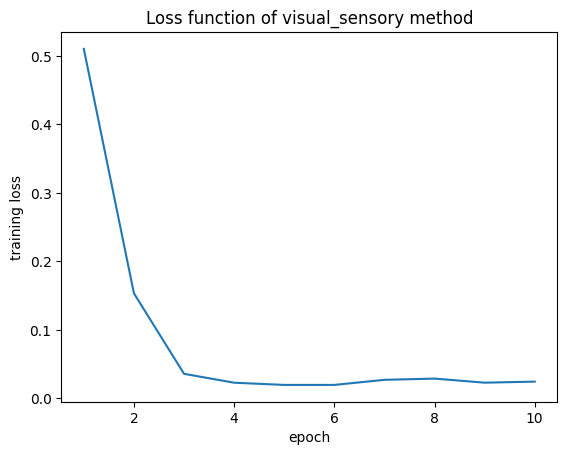

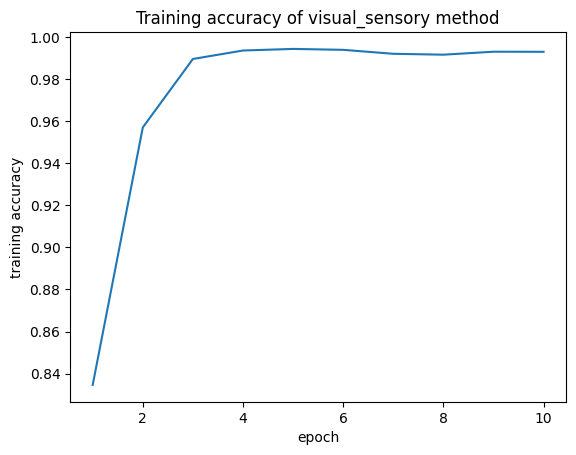

In [11]:
# 开始训练
import matplotlib.pyplot as plt

loss_train_con = []
acc_train_con = []
 
epoch = 10

max_acc = 0 # the best ever model

iterr=[1,2,3,4,5,6,7,8,9,10]
device = torch.device("cuda:0" if torch.cuda.is_available () else "cpu")

for t in range(epoch):
    print(f"epoch{t+1}\n--------------")
    train_loss, train_acc = train(train_dataloader2, model2, loss_fn2, optimizer2,device)
    
    #print("train_loss: ",train_loss); 
    loss_train_con.append(train_loss)
    #print("train_acc: ",train_acc); 
    acc_train_con.append(train_acc)
    
    if train_acc > max_acc:
        print(f"save best model, 第{t+1}轮")
        max_acc = train_acc
        torch.save(model2,"moving_visual_sensory.pth")
        
        
plt.figure(1)
plt.plot(iterr,loss_train_con)
plt.title('Loss function of visual_sensory method')
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.show()

plt.figure(2)
plt.plot(iterr,acc_train_con)
plt.title('Training accuracy of visual_sensory method')
plt.xlabel('epoch')
plt.ylabel('training accuracy')
plt.show()

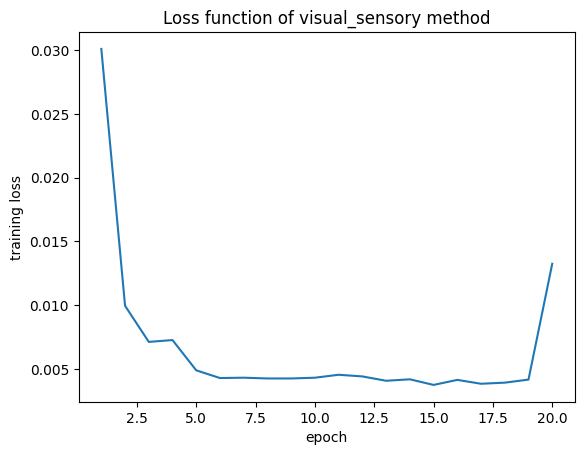

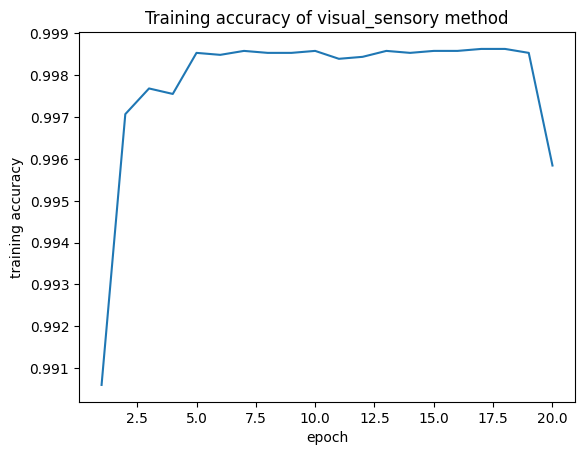

In [11]:
import matplotlib.pyplot as plt

iterr=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

plt.figure(1)
plt.plot(iterr,loss_train_con)
plt.title('Loss function of visual_sensory method')
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.show()

plt.figure(2)
plt.plot(iterr,acc_train_con)
plt.title('Training accuracy of visual_sensory method')
plt.xlabel('epoch')
plt.ylabel('training accuracy')
plt.show()

In [12]:
# 定义训练函数
# val部分不需要损失函数loss_fn和优化器optimizer,只需要求出对不对就行了
def test(dataloader, model):
    current,n = 0.0,0
    for batch_num, (x, label) in enumerate(dataloader):
        # 前向传播
        image, label = x.to(device), label.to(device)
        output = model(image)
        _, pred = torch.max(output, axis=1)
        # label,pred = merge_categories(label,pred)
        print("label: ",label);print("pred: ",pred)
        
        cur_acc = torch.sum(label == pred)/output.shape[0]
        
        current += cur_acc.item()
        n=n+1

    test_acc = current/n
    print('test_acc:' + str(test_acc))
    return test_acc

In [13]:
model2 = torch.load('moving_visual_sensory.pth')
device = torch.device("cuda:0" if torch.cuda.is_available () else "cpu") ; model2 = model2.to(device) # deploy model on device
model2.eval() # ready for the test

test_acc2 = test(val_dataloader2, model2)

label:  tensor([8, 9, 2, 2, 1, 0, 0, 8, 3, 4, 7, 8, 8, 1, 5, 8, 2, 7, 1, 2, 0, 0, 0, 3,
        8, 1, 0, 6, 2, 7, 5, 7, 2, 1, 5, 8, 5, 8, 3, 8, 1, 7, 7, 0, 9, 0, 0, 4,
        6, 8, 3, 3, 5, 6, 4, 8, 4, 9, 3, 9, 7, 4, 3, 9], device='cuda:0')
pred:  tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0')
label:  tensor([5, 2, 8, 0, 9, 2, 7, 6, 9, 0, 6, 0, 5, 5, 1, 5, 9, 3, 6, 4, 2, 2, 0, 2,
        4, 7, 5, 1, 1, 5, 1, 9, 0, 1, 1, 9, 5, 4, 5, 7, 4, 5, 1, 4, 9, 1, 3, 5,
        1, 3, 8, 6, 3, 9, 2, 7, 3, 0, 1, 3, 9, 6, 3, 9], device='cuda:0')
pred:  tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0')
label:  tensor([4, 6, 8, 7, 2, 5, 